# Live Simulated Trading

The live trading system works by subscribing to a brokers (FTX) websocket and processing all changes in the orderbook. This is filtered for the best bid and best ask in order to calculate the mid-price as ``the price''. No slippage or fees are taken into account as the small order assumption holds here (our market orders will have no impact on the price). This price fluctuations are accumulated for a certain period which then forms one data point for the SCINet model (open, high, low, close). These datapoints are accumulated to form a sequence that is the input to the SCINet model. Then, similar to the backtesting system. 

As we are dealing with a highly asynchronous system the different components described above are divided in three separate threads: websocket thread, data preparation thread, scinet model strategy thread. This way, the individual processes run in parallel allowing each of the processes to not be held back by the others.

In [1]:
import os
import sys

cwd = os.getcwd()
BASE_DIR = os.path.dirname(os.path.dirname(cwd))

sys.path.insert(0, BASE_DIR) #add base to path for relative imports

sys.path.insert(0, "data/")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from threading import Thread

from utils.websocket_manager import WebsocketManager #handles ws connection with broker

from utils.data_prepper import SCINET_data_prepper #prepares data in samples for SCINet

from utils.live_scinet import LiveSCINET #live SCINet model for prediction

## Dashboard

The following code builds and updates a live dashboard using matplotlib. The data is requested from the live SCINet strategy and the portfolio that tracks the balance of the live model during the trading session. The plots are updates as fast as possible using a matplotlib FuncAnimation.

In [3]:
def live_plot(ws_manager, data_prepper, live_model):
    fig = plt.figure(figsize=(8, 8))

    market_axis = plt.subplot2grid(shape = (3, 1), loc = (0, 0))
    sample_axis = plt.subplot2grid(shape = (3, 1), loc = (1, 0))
    balance_axis = plt.subplot2grid(shape = (3, 1), loc = (2, 0))


    market_axis.set_title(ws_manager.markets[0])
    sample_axis.set_title(f"processed sample")
    balance_axis.set_title(f"live total equity - #longs: {live_model.long_count} #shorts: {live_model.short_count}")

    axes_markets = [market_axis]

    ani = animation.FuncAnimation(fig, update, fargs = ([axes_markets, sample_axis, balance_axis], 
                                                        ws_manager, 
                                                        data_prepper,
                                                        live_model), interval=10)

    plt.show()

def update(t, axes, ws_manager, data_prepper, live_model):
    axes_markets = axes[0]
    samples_axis = axes[1]
    balance_axis = axes[2]

    #market(s) plot
    for i, market in enumerate(ws_manager.markets):
        times = ws_manager.market_data[market]["times"]
        bids = ws_manager.market_data[market]["bids"]
        asks = ws_manager.market_data[market]["asks"]

        if len(times) == len(bids) == len(asks): #sometimes threads out of sync
            try:
                axes_markets[i].clear()
                axes_markets[i].fill_between(times, asks, (np.array(bids) + np.array(asks))/2, color = "red", label = "best ask")
                axes_markets[i].fill_between(times, bids, (np.array(bids) + np.array(asks))/2, color = "green", label = "best bid")
                axes_markets[i].plot(times, (np.array(bids) + np.array(asks))/2, color = "black", label = "mid-price")
                axes_markets[i].set_title(f"market: {ws_manager.markets[i]}")
                axes_markets[i].legend(bbox_to_anchor=(1,1), loc="upper left")
            except Exception as error:
                print(f"error plotting with message: {error}")
        else:
            print(f"out of sync")

    if t % 5 == 0:
        #model data plot


        market_data = data_prepper.data[ws_manager.markets[0]]

        if type(live_model.prediction) != type(None):
            samples_axis.clear()
            samples_axis.plot(range(live_model.X_LEN), live_model.current_sample, color = "black", label = "sample")

            if live_model.planned_trade != None:
                trade_type = live_model.planned_trade["type"]
            else:
                trade_type = None

            color = (trade_type == "EXIT_LONG") * "green" + \
                    (trade_type == "EXIT_SHORT") * "red" + \
                    (trade_type == None) * "gray"

            samples_axis.plot(  range(live_model.X_LEN, live_model.X_LEN + live_model.Y_LEN), 
                                live_model.prediction, 
                                color = color
                            )
            samples_axis.scatter(   range(live_model.X_LEN, live_model.X_LEN + live_model.Y_LEN), 
                                    live_model.prediction, 
                                    color = color,
                                    s = 5,
                                    label = "prediction"
                                )

            samples_axis.set_title("processed sample")
            samples_axis.legend(bbox_to_anchor=(1,1), loc="upper left")

        #portfolio plot
        if type(live_model.prediction) != type(None): 
                min_len = min(len(live_model.current_times), len(live_model.equity)) #can get out of sync, plot shortest
                balance_axis.clear()
                balance_axis.plot(list(live_model.current_times)[:min_len], list(live_model.equity)[:min_len], color = "black")
                balance_axis.set_title(f"live total equity - #longs: {live_model.long_count} #shorts: {live_model.short_count}")

    if t % 500 == 0:
        print(f"fixing layout...")

        plt.tight_layout()

Building model...
Input did not contain model weights, using random SCINET model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 168, 4)]     0           []                               
                                                                                                  
 Block_0 (SCINet)               (None, 20, 4)        121744      ['input_1[0][0]']                
                                                                                                  
 tf.concat (TFOpLambda)         (None, 188, 4)       0           ['input_1[0][0]',                
                                                                  'Block_0[0][0]']                
                                                                                                  
 cropping1d (

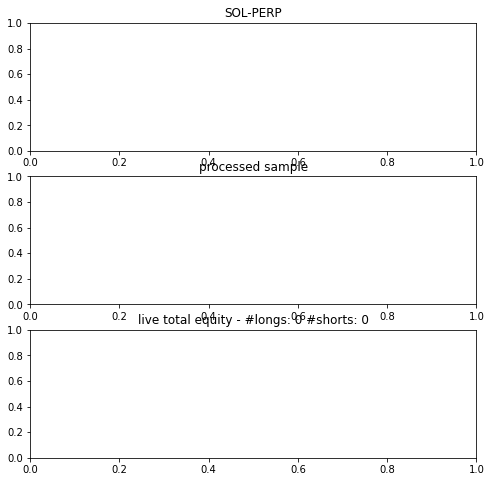

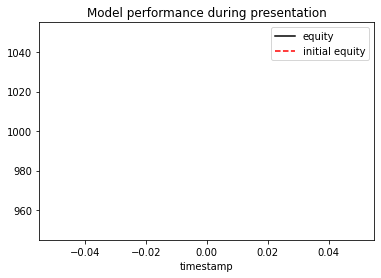

'NoneType' object has no attribute 'is_ssl'


In [4]:
URL = "wss://ftx.com/ws/" #websocket endpoint of broker

max_queue_len = 1000 #only display the latest 1000 points for speed


markets = ["SOL-PERP"] #market to trade on

X_LEN = 168 #input sample length
Y_LEN = [20, 20] #output sample length

#websocket handler
ws_manager = WebsocketManager(  URL = URL,
                                markets = markets,
                                max_len = max_queue_len
                            )

update_period = 1 #second, take data sample every second
#prepare data in samples for SCINet
data_prepper = SCINET_data_prepper( ws_manager = ws_manager,
                                    X_LEN = X_LEN,
                                    Y_LEN = Y_LEN,
                                    update_period = update_period
                                ) 

model_weights = "model_weights/BTCUSD_1652131187" #trained model
begin_cash = 1000 #beginning equity

#live scinet model
live_model = LiveSCINET(prepper = data_prepper,
                        n_features = int(4 * len(markets)),
                        output_dim =  [int(4 * len(markets))] * 2,
                        X_LEN = X_LEN,
                        Y_LEN = Y_LEN,
                        threshold = 0.25,
                        model_weights = None, # WARNING # TODO
                        begin_cash = begin_cash,
                    )

ws_thread = Thread(target = ws_manager.connect)
prepper_thread = Thread(target = data_prepper.run)
scinet_thread = Thread(target = live_model.run)

ws_thread.start()
prepper_thread.start()
scinet_thread.start()


live_plot(ws_manager, data_prepper, live_model)


#in case plot is closed -> stop all threads
ws_manager.stop()
data_prepper.stop()
live_model.stop()


performance = live_model.historic_equity
plt.figure()
plt.plot(performance, color = "black", label = "equity")
plt.hlines(begin_cash, 0, len(performance), color = "red", linestyle = "--", label = "initial equity")
plt.xlabel("timestamp")
plt.title("Model performance during presentation")
plt.legend()
plt.show()